<a href="https://colab.research.google.com/github/ThokozileKhosa/COS801_Project/blob/main/COS801_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/DavideA/c3d-pytorch.git

Cloning into 'c3d-pytorch'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39 (from 1)
Receiving objects: 100% (39/39), 12.81 MiB | 43.01 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
cd /content/c3d-pytorch/


/content/c3d-pytorch


In [ ]:
!wget http://imagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
!ls

--2024-11-09 19:26:56--  http://imagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
Resolving imagelab.ing.unimore.it (imagelab.ing.unimore.it)... 155.185.48.35
Connecting to imagelab.ing.unimore.it (imagelab.ing.unimore.it)|155.185.48.35|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://aimagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle [following]
--2024-11-09 19:26:58--  https://aimagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
Resolving aimagelab.ing.unimore.it (aimagelab.ing.unimore.it)... 155.185.48.35
Connecting to aimagelab.ing.unimore.it (aimagelab.ing.unimore.it)|155.185.48.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319966434 (305M) [application/octet-stream]
Saving to: ‘c3d.pickle’

c3d.pickle          100%[===================>] 305.14M  3.53MB/s    in 89s     

2024-11-09 19:28:28 (3.43 MB/s) - ‘c3d.pickle’ saved [319966434/319966434]

C3D_model.py  c3d.pickle  data	labels.txt  LICENSE

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split


In [ ]:
def extract_frames_from_video(video_path, output_dir, frame_size=(112, 112)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []
    success, frame = cap.read()
    while success:
        frame = cv2.resize(frame, frame_size)  # Resize to 112x112 as expected by C3D
        frames.append(frame)
        success, frame = cap.read()

    cap.release()

    # Save frames in the output directory
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(output_dir, f"frame_{i:04d}.png"), frame)

    return len(frames)  # Return the number of frames extracted

In [ ]:
def create_clips_from_frames(frames_dir, clip_size=16):
    frame_paths = sorted(glob(os.path.join(frames_dir, "*.png")))
    clips = []
    total_frames = len(frame_paths)

    # Split frames into clips with padding for remaining frames if needed
    for i in range(0, total_frames, clip_size):
        clip_frames = frame_paths[i:i + clip_size]
        if len(clip_frames) < clip_size:
            # Padding if clip has fewer than `clip_size` frames
            clip_frames += [clip_frames[-1]] * (clip_size - len(clip_frames))
        clips.append(clip_frames)

    return clips


In [ ]:
def prepare_data_for_training(video_paths, label, clip_size=16):
    data = []
    labels = []

    for video_path in tqdm(video_paths):
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        frames_dir = f"/content/frames/{video_name}"

        # Extract frames from video
        extract_frames_from_video(video_path, frames_dir)

        # Create clips from frames
        clips = create_clips_from_frames(frames_dir, clip_size=clip_size)

        for clip in clips:
            data.append(clip)
            labels.append(label)

    return data, labels


In [ ]:
# Paths to videos
normal_videos = glob('/content/drive/MyDrive/CSC 801/Project/Data_1/Normal_Abnormal_Crowd/Normal Crowds/*')
abnormal_videos = glob('/content/drive/MyDrive/CSC 801/Project/Data_1/Normal_Abnormal_Crowd/Abnormal Crowds/*')

# Process normal and abnormal videos
normal_data, normal_labels = prepare_data_for_training(normal_videos, label=0, clip_size=16)
abnormal_data, abnormal_labels = prepare_data_for_training(abnormal_videos, label=1, clip_size=16)

# Combine and split into training and testing sets
all_data = normal_data + abnormal_data
all_labels = normal_labels + abnormal_labels

train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        clip_frames = self.data[idx]
        label = self.labels[idx]

        # Load frames and stack them into a tensor
        clip = [cv2.imread(frame) for frame in clip_frames]
        clip = np.stack(clip, axis=0)  # Shape: (clip_size, H, W, C)
        clip = np.transpose(clip, (3, 0, 1, 2))  # Convert to (C, clip_size, H, W)
        clip = torch.tensor(clip, dtype=torch.float32) / 255.0  # Normalize to [0, 1]

        return clip, label

# Create data loaders
train_dataset = VideoDataset(train_data, train_labels)
test_dataset = VideoDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch.optim as optim
from C3D_model import C3D
import torch.nn as nn
import time

# Load pre-trained model
model = C3D()
#model.load_state_dict(torch.load('c3d.pickle'))
model.load_state_dict(torch.load('c3d.pickle', weights_only=True))
model.fc8 = nn.Linear(4096, 2)  # Modify output layer for binary classification
model.softmax = nn.Softmax(dim=1)


# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_start = time.time()
    for batch_idx, (clips, labels) in enumerate(train_loader):
        batch_start = time.time()
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f"Batch {batch_idx + 1} - Forward pass: {time.time() - batch_start:.2f}s")

    print(f"Epoch [{epoch+1}/{num_epochs}] complete, Total Time: {time.time() - epoch_start:.2f}s, Loss: {loss.item():.4f}")


# Save the fine-tuned model
torch.save(model.state_dict(), 'c3d_finetuned.pth')

Batch 1 - Forward pass: 1.40s
Batch 2 - Forward pass: 0.02s
Batch 3 - Forward pass: 0.24s
Batch 4 - Forward pass: 0.26s
Batch 5 - Forward pass: 0.26s
Batch 6 - Forward pass: 0.27s
Batch 7 - Forward pass: 0.27s
Batch 8 - Forward pass: 0.26s
Batch 9 - Forward pass: 0.26s
Batch 10 - Forward pass: 0.26s
Batch 11 - Forward pass: 0.26s
Batch 12 - Forward pass: 0.27s
Batch 13 - Forward pass: 0.26s
Batch 14 - Forward pass: 0.26s
Batch 15 - Forward pass: 0.26s
Batch 16 - Forward pass: 0.26s
Batch 17 - Forward pass: 0.26s
Batch 18 - Forward pass: 0.26s
Batch 19 - Forward pass: 0.26s
Batch 20 - Forward pass: 0.26s
Batch 21 - Forward pass: 0.26s
Batch 22 - Forward pass: 0.26s
Batch 23 - Forward pass: 0.26s
Batch 24 - Forward pass: 0.26s
Batch 25 - Forward pass: 0.26s
Batch 26 - Forward pass: 0.26s
Batch 27 - Forward pass: 0.26s
Batch 28 - Forward pass: 0.26s
Batch 29 - Forward pass: 0.26s
Batch 30 - Forward pass: 0.27s
Batch 31 - Forward pass: 0.26s
Batch 32 - Forward pass: 0.27s
Batch 33 - Forwar

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for clips, labels in test_loader:
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 80.92%


<ipython-input-13-8ba9a7bf7a57>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('c3d.pickle'))
/usr/local/lib/python3.10/dist-packages/torc

Epoch [1/20], Train Loss: 0.5390, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [2/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [3/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [4/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [5/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [6/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [7/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [8/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [9/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [10/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [11/20], Train Loss: 0.5337, Train Acc: 77.85%, Test Loss: 0.5041, Test Acc: 80.92%
Epoch [12/20], Trai

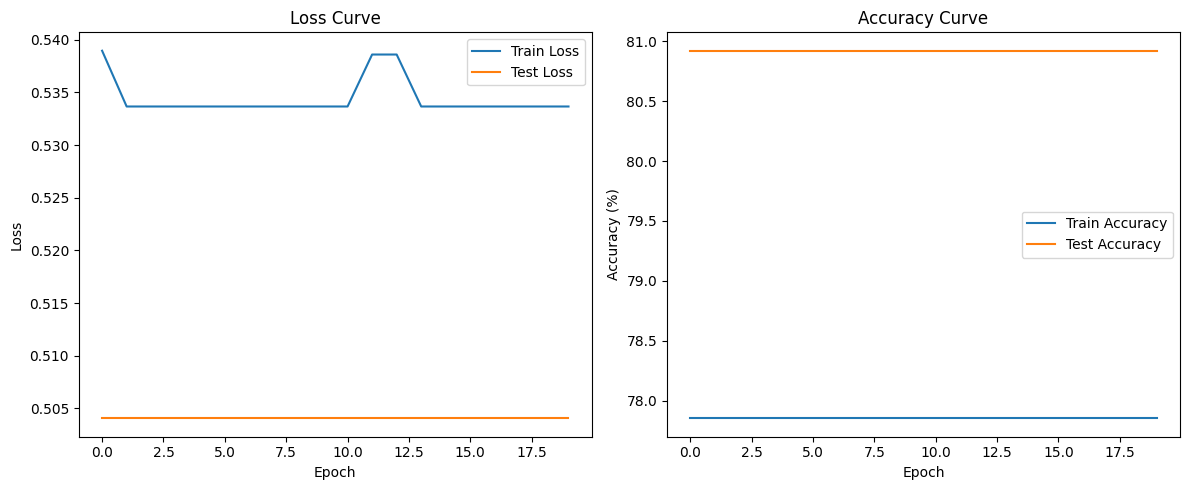

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load pre-trained model
model = C3D()
model.load_state_dict(torch.load('c3d.pickle'))
model.fc8 = nn.Linear(4096, 2)  # Modify output layer for binary classification

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Variables to store loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store train loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store test loss and accuracy for this epoch
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


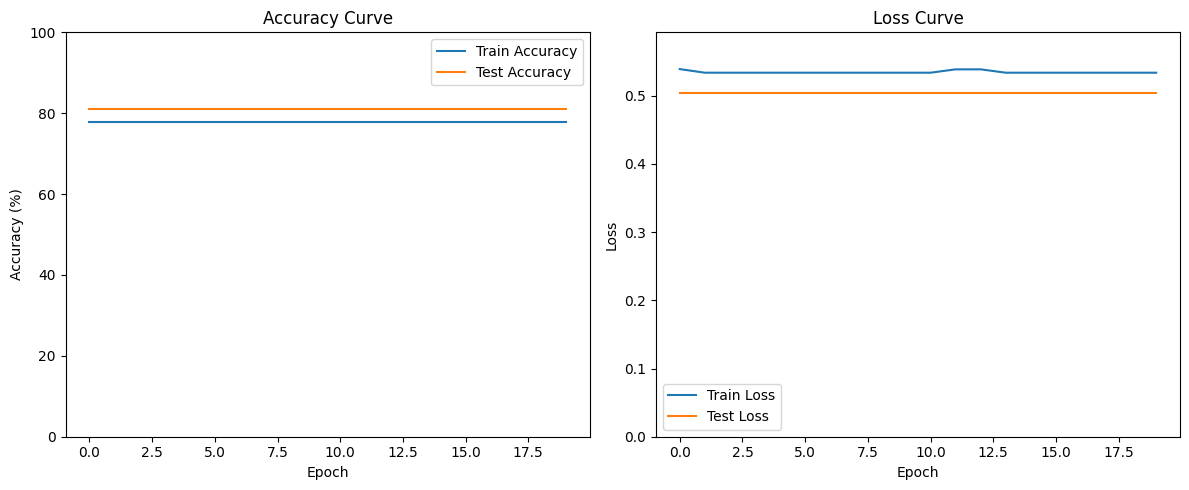

In [ ]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.ylim(0, 100)  # Setting y-axis from 0 to 100% for accuracy
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.ylim(0, max(max(train_losses), max(test_losses)) * 1.1)  # Setting y-axis from 0 to slightly above max value
plt.legend()

plt.tight_layout()
plt.show()

# Freezing Layers

In [ ]:
# Load pre-trained model
tuned_model = C3D()
tuned_model.load_state_dict(torch.load('c3d.pickle'))

# Modify output layer for binary classification
tuned_model.fc8 = nn.Linear(4096, 2)

# Freeze all layers except the last layer (fc8)
for param in tuned_model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze the parameters of the last layer (fc8) for training
for param in tuned_model.fc8.parameters():
    param.requires_grad = True  # Only train the last layer

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tuned_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_model.parameters(), lr=0.1)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    tuned_model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = tuned_model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the fine-tuned model
torch.save(tuned_model.state_dict(), 'c3d_finetuned.pth')


<ipython-input-15-566c9d973d7f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tuned_model.load_state_dict(torch.load('c3d.pickle'))


Epoch [1/10], Loss: 0.5340, Accuracy: 77.85%
Epoch [2/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [3/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [4/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [5/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [6/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [7/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [8/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [9/10], Loss: 0.5337, Accuracy: 77.85%
Epoch [10/10], Loss: 0.5337, Accuracy: 77.85%


<ipython-input-18-0274d51a3d0d>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tuned_model.load_state_dict(torch.load('c3d.pickle'))


Epoch [1/20], Loss: 0.6540, Accuracy: 65.45%
Epoch [2/20], Loss: 0.5339, Accuracy: 77.85%
Epoch [3/20], Loss: 0.7157, Accuracy: 59.50%
Epoch [4/20], Loss: 0.5826, Accuracy: 73.39%
Epoch [5/20], Loss: 0.5355, Accuracy: 77.69%
Epoch [6/20], Loss: 0.5353, Accuracy: 77.69%
Epoch [7/20], Loss: 0.5392, Accuracy: 77.36%
Epoch [8/20], Loss: 0.5464, Accuracy: 77.02%
Epoch [9/20], Loss: 0.6235, Accuracy: 68.76%
Epoch [10/20], Loss: 0.5383, Accuracy: 77.52%
Epoch [11/20], Loss: 0.6338, Accuracy: 68.43%
Epoch [12/20], Loss: 0.7786, Accuracy: 53.72%
Epoch [13/20], Loss: 0.5383, Accuracy: 77.52%
Epoch [14/20], Loss: 0.6380, Accuracy: 67.27%
Epoch [15/20], Loss: 0.5355, Accuracy: 77.69%
Epoch [16/20], Loss: 0.5419, Accuracy: 77.69%
Epoch [17/20], Loss: 0.5468, Accuracy: 77.02%
Epoch [18/20], Loss: 0.7496, Accuracy: 56.69%
Epoch [19/20], Loss: 0.7517, Accuracy: 56.36%
Epoch [20/20], Loss: 0.5338, Accuracy: 77.85%


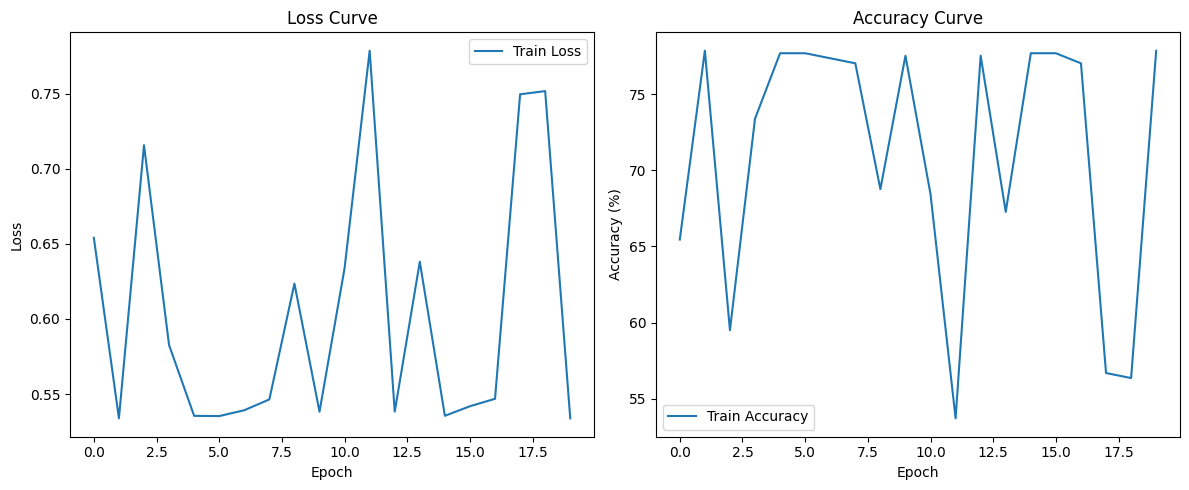

In [ ]:
import torch.optim as optim
from C3D_model import C3D
import torch.nn as nn
import matplotlib.pyplot as plt

# Load pre-trained model
tuned_model = C3D()
tuned_model.load_state_dict(torch.load('c3d.pickle'))

# Modify output layer for binary classification
tuned_model.fc8 = nn.Linear(4096, 2)

# Freeze all layers except the last layer (fc8)
for param in tuned_model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze the parameters of the last layer (fc8) for training
for param in tuned_model.fc8.parameters():
    param.requires_grad = True  # Only train the last layer

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tuned_model.to(device)

# Define loss and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_model.parameters(), lr=0.1, weight_decay=0.01)  # L2 regularization via weight_decay

# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    tuned_model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = tuned_model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the fine-tuned model
torch.save(tuned_model.state_dict(), 'c3d_finetuned.pth')

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()

        # 3D convolutional layers
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)

        # Pooling and dropout layers
        self.pool = nn.MaxPool3d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Initialize fc1 with a placeholder; the correct size will be set dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        # Convolutional layers with ReLU and max-pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Calculate flattened size for fc1 dynamically
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)  # Set fc1 dynamically and move to device

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification

        return x

# Initialize the model and move to GPU if available
model = CNN3D().to(device)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    # Training phase
    for clips, labels in train_loader:
        # Move data and labels to the same device as the model
        clips, labels = clips.to(device), labels.to(device).float()  # Convert labels to float

        optimizer.zero_grad()
        outputs = model(clips).view(-1)  # Reshape outputs to match labels shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Convert to binary predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for clips, labels in test_loader:
          clips, labels = clips.to(device), labels.to(device).float()  # Ensure labels are Float
          outputs = model(clips).view(-1)  # Reshape outputs to match labels shape
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          predicted = (outputs > 0.5).float()  # Convert to binary predictions
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    test_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    test_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), '3dcnn_trained.pth')


Epoch [1/20], Train Loss: 0.2925, Train Accuracy: 89.09%, Validation Loss: 0.1794, Validation Accuracy: 92.76%
Epoch [2/20], Train Loss: 0.2649, Train Accuracy: 90.91%, Validation Loss: 0.1634, Validation Accuracy: 94.74%
Epoch [3/20], Train Loss: 0.2413, Train Accuracy: 91.74%, Validation Loss: 0.1485, Validation Accuracy: 96.05%
Epoch [4/20], Train Loss: 0.2544, Train Accuracy: 90.74%, Validation Loss: 0.1433, Validation Accuracy: 96.05%
Epoch [5/20], Train Loss: 0.2331, Train Accuracy: 91.24%, Validation Loss: 0.1325, Validation Accuracy: 97.37%
Epoch [6/20], Train Loss: 0.1992, Train Accuracy: 93.39%, Validation Loss: 0.1199, Validation Accuracy: 96.05%
Epoch [7/20], Train Loss: 0.2178, Train Accuracy: 93.39%, Validation Loss: 0.1215, Validation Accuracy: 97.37%
Epoch [8/20], Train Loss: 0.1963, Train Accuracy: 92.73%, Validation Loss: 0.1195, Validation Accuracy: 97.37%
Epoch [9/20], Train Loss: 0.1901, Train Accuracy: 94.55%, Validation Loss: 0.1101, Validation Accuracy: 96.71%
E

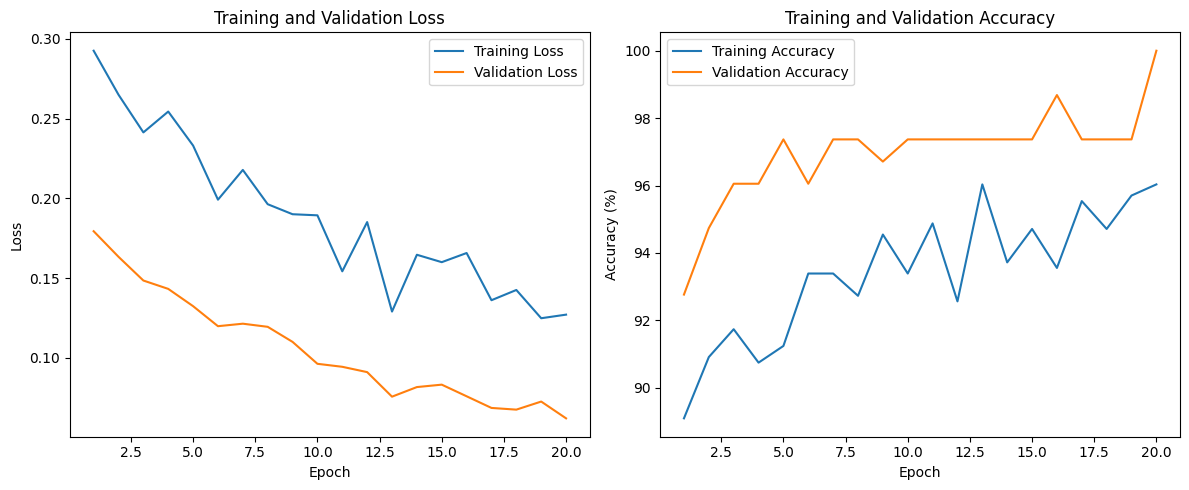

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Define training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for clips, labels in dataloader:
        clips, labels = clips.to(device), labels.to(device, dtype=torch.float)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(clips).view(-1)  # Ensure model output is (batch_size,)

        # Ensure labels are also of shape (batch_size,)
        labels = labels.view(-1)  # Squeeze labels to remove any extra dimensions

        # Compute loss
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Define validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for clips, labels in dataloader:
            clips, labels = clips.to(device), labels.to(device, dtype=torch.float)

            # Forward pass
            outputs = model(clips).view(-1)
            labels = labels.view(-1)  # Ensure labels are of shape (batch_size,)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy (round outputs to 0 or 1)
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()

    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy


In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, criterion, and optimizer
model = Attention3DCNN(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training settings
num_epochs = 20  # Set as needed
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store losses and accuracy
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Accuracy: {val_accuracy:.4f}")

Epoch [1/20] - Train Loss: 0.5379 - Val Loss: 0.4578 - Val Accuracy: 0.8092
Epoch [2/20] - Train Loss: 0.5125 - Val Loss: 0.4556 - Val Accuracy: 0.8092
Epoch [3/20] - Train Loss: 0.5085 - Val Loss: 0.4476 - Val Accuracy: 0.8092
Epoch [4/20] - Train Loss: 0.5017 - Val Loss: 0.4490 - Val Accuracy: 0.8092
Epoch [5/20] - Train Loss: 0.4985 - Val Loss: 0.4424 - Val Accuracy: 0.8092
Epoch [6/20] - Train Loss: 0.4979 - Val Loss: 0.4551 - Val Accuracy: 0.8092
Epoch [7/20] - Train Loss: 0.4989 - Val Loss: 0.4398 - Val Accuracy: 0.8092
Epoch [8/20] - Train Loss: 0.4886 - Val Loss: 0.4468 - Val Accuracy: 0.8092
Epoch [9/20] - Train Loss: 0.4878 - Val Loss: 0.4332 - Val Accuracy: 0.8092
Epoch [10/20] - Train Loss: 0.4786 - Val Loss: 0.4177 - Val Accuracy: 0.8092
Epoch [11/20] - Train Loss: 0.4736 - Val Loss: 0.4175 - Val Accuracy: 0.8092
Epoch [12/20] - Train Loss: 0.4639 - Val Loss: 0.4015 - Val Accuracy: 0.8092
Epoch [13/20] - Train Loss: 0.4534 - Val Loss: 0.4123 - Val Accuracy: 0.8092
Epoch [1

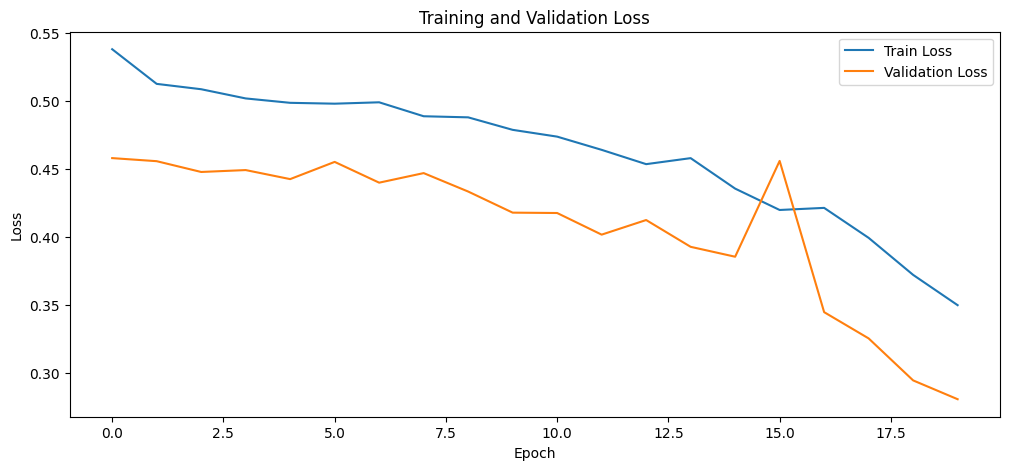

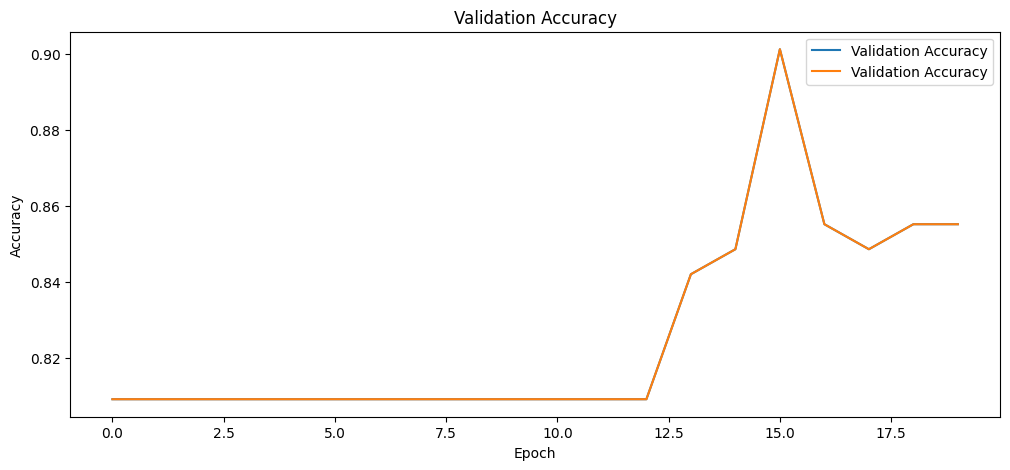

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()
